# Create media designs suggested by ART

We use ART to provide suggested designs for media components for which to get phenotypic data. 

For DBTL 3 we create 12 designs from an exploratory mode with $\alpha=0.9$, 3 designs from the exploration mode ($\alpha=0$) and 1 design being close to the standard media as a control, totalling 16 desigsn in triplicates. 

Tested using **ART 3.9.4** kernel on jprime.lbl.gov

## Inputs and output

**Required files to run this notebook:**
- `Putida_media_bounds.csv`
- `standard_recipe_concentrations.csv`
- EDD study slug(s)

**File generated by running this notebook**

- 

## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [1]:
import sys
sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
sys.path.append('../')
import re
import warnings
    
from art.core import *
import art.plot as plot
import edd_utils as eddu

from core import designs_pairwise

## User parameters

In [2]:
CYCLE = 3

user_params = {
    'bounds_file': f'../data/flaviolin/Putida_media_bounds.csv',
    'output_file_path': f'../data/flaviolin/DBTL{CYCLE}', # Folder for output files,
    'standard_media_file': '../data/flaviolin/standard_recipe_concentrations.csv',
    'study_slug_1': 'combinatorial-media-for-flaviolin-dbtl1-ed1e',
    'study_slug_2': 'combinatorial-media-for-flaviolin-dbtl-2',
    'edd_server': 'edd.jbei.org',
    'username': 'tradivojevic',
}


Specify which components to explore and which response to optimize:

In [3]:
user_params['components'] = [
    'H3BO3',
    'K2SO4',
    'K2HPO4',
    'FeSO4',
    'NH4Cl',
    'MgCl2',
    'NaCl',
    '(NH4)6Mo7O24',
    'CoCl2',
    'CuSO4',
    'MnSO4',
    'ZnSO4'
]

user_params['response'] = 'OD340'

Here we specify how many instances (designs) we want to create and how many replicates: 

In [4]:
user_params['n_instances_explor'] = 12
user_params['n_instances_exploit'] = 3
user_params['n_replicates'] = 3 

## Load the data

In [5]:
study_slug_1 = user_params['study_slug_1']
study_slug_2 = user_params['study_slug_2']
edd_server = user_params['edd_server']
username = user_params['username']

In [6]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for tradivojevic:  ··············


OK! Connection to EDD successful. We will try to load data from EDD...


In [7]:
try:
    df_1 = eddu.export_study(session, study_slug_1, edd_server=edd_server)
    df_2 = eddu.export_study(session, study_slug_2, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')



  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

In [8]:
df_1.head(2)

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,148494,Combinatorial media for flaviolin DBTL1,148495,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,148543,C1_WA1_A4-R1,NaN,Optical Density,0,NaN,0.4422,48.0
1,148494,Combinatorial media for flaviolin DBTL1,148496,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,148544,C1_WA1_A4-R2,NaN,Optical Density,0,NaN,0.3405,48.0


In [9]:
df_2.head(2)

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,148639,Combinatorial media for flaviolin DBTL 2,148640,C2_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,148688,C2_WA1_A4-R1,NaN,Optical Density,0,NaN,0.3717,48.0
1,148639,Combinatorial media for flaviolin DBTL 2,148641,C2_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,148689,C2_WA1_A4-R2,NaN,Optical Density,0,NaN,0.3748,48.0


Concatenate the two studies:

In [10]:
df = df_1.append(df_2)

Drop unnecessary columns:

In [11]:
df = df.loc[:,['Line Name','Line Description','Protocol','Value']]
df.head()

,Line Name,Line Description,Protocol,Value
0,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4422
1,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3405
2,C1_WA1_A4-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3397
3,C1_WA1_A4-R4,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3602
4,C1_WA5_A8-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.2699


Pivot the dataframe to include columns for all protocols:

In [12]:
df = df.pivot(index=["Line Name", "Line Description"], columns="Protocol", values="Value")
df.reset_index(inplace=True)
df.head()

Protocol,Line Name,Line Description,OD340,OD600
0,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.4422,2.019
1,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3405,0.516
2,C1_WA1_A4-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3397,0.436
3,C1_WA1_A4-R4,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3602,0.623
4,C1_WA5_A8-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.2699,0.699


### Adding media information to the data frame

Add columns for each component:

In [13]:
components = re.split(': |, ', df['Line Description'][0])[::2]
for comp in components:
    df[comp] = None


And assign values for each component and line:

In [14]:
for i in range(len(df)):
    values = re.split(': |, ', df['Line Description'][i])[1::2]
    for c, value in enumerate(values):
        df.iloc[i, (4+c)] = float(value)

df.drop(columns='Line Description', inplace=True)
df.tail()

Protocol,Line Name,OD340,OD600,MOPS,Tricine,H3BO3,Glucose,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
91,C2_WF1_F4-R4,0.3065,0.097,40.0,4.0,0.002467,20.0,0.119844,1.762672,0.081953,8.821329,0.279924,25.780235,0.000205,0.000291,0.000455,0.00017,0.000743
92,C2_WF5_F8-R1,0.2934,0.631,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095
93,C2_WF5_F8-R2,0.2912,0.593,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095
94,C2_WF5_F8-R3,0.3004,0.601,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095
95,C2_WF5_F8-R4,0.2990,0.671,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095


Define the control lines:

In [15]:
control_lines = df[df['Line Name'].str.find('WF5_F8') > 0]


How many designs improve response over the standard recipe?

In [16]:
control_response = np.max(control_lines['OD340'])
num_improved_response = np.sum(df['OD340'] > control_response)
num_designs = len(df) - len(control_lines)
print(f'{num_improved_response} samples out of {num_designs} improve over the standard in terms of OD340 ({num_improved_response/num_designs*100:.2f}%).')


49 samples out of 88 improve over the standard in terms of OD340 (55.68%).


### Convert the data to EDD format

Pivot the dataframe back to EDD format, including all the components names and protocols:

In [17]:
df_stacked = df.set_index('Line Name').stack().reset_index()
df_stacked.columns = ['Line Name', 'Measurement Type', 'Value']
df_stacked.head()

,Line Name,Measurement Type,Value
0,C1_WA1_A4-R1,OD340,0.4422
1,C1_WA1_A4-R1,OD600,2.019
2,C1_WA1_A4-R1,MOPS,40.0
3,C1_WA1_A4-R1,Tricine,4.0
4,C1_WA1_A4-R1,H3BO3,0.003744


# Media designs recommendations

## ART generated media

Define a dictionary that contains the settings that ART will use to find the recommended designs:

In [5]:
art_params = {
    'input_vars': user_params['components'],
    'response_vars': [user_params['response']],
    'bounds_file': user_params['bounds_file'], # file with bounds# input variables, i.e. features
    'seed': 10,                                           # seed for number random generator
    'cross_val': True,
    'recommend': False,
    'output_directory': user_params['output_file_path'],  # directory to store this output
    'verbose': 1
}


We will first run only model building part and then proceed with optimization using the two modes - exploration and exploitation>

In [6]:
user_params['alpha_explor'] = 0.9
user_params['alpha_exploit'] = None

With the configuration stored in art_params, we now run ART:

In [7]:
run_art = False

In [8]:
%%time
warnings.filterwarnings("ignore")
if run_art:
    art = RecommendationEngine(df_stacked, **art_params)
else:
    with open(os.path.join(art_params['output_directory'], 'art.pkl'), 'rb') as output:
        art = pickle.load(output)

CPU times: user 178 ms, sys: 326 ms, total: 505 ms
Wall time: 7.36 s


In [15]:
assert "TPOT Regressor" in art.model_df[0].index


In [21]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.156714,57.348077,0.131917,0.041961,-1.935655
Random Forest Regressor,0.079044,24.143732,0.067482,0.010802,0.244298
TPOT Regressor,0.069401,20.339842,0.072888,0.010129,0.291360
Support Vector Regressor,0.088007,31.128698,0.065739,0.012067,0.155783
Kernel Ridge Regressor,0.155240,45.734043,0.109071,0.035996,-1.518320
K-NN Regressor,0.099640,30.370290,0.082354,0.016710,-0.169073
Gaussian Process Regressor,0.082306,24.942214,0.081339,0.013390,0.063192
Gradient Boosting Regressor,0.078375,24.409614,0.068026,0.010770,0.246502
Ensemble Model,0.069183,20.335720,0.070001,0.009686,0.322329


### Exploitation recommendations

In [21]:
%%time
art.niter = 100000
art.alpha = user_params['alpha_exploit']
draws = art.parallel_tempering_opt()


Finished 2.00 percent in 9.317060 s Acceptance rate = 0.5945Adding DE jump with weight 20
Finished 99.00 percent in 345.543275 s Acceptance rate = 0.435778
Run Complete
CPU times: user 5min 36s, sys: 1.9 s, total: 5min 38s
Wall time: 5min 48s


In [22]:
art.num_recommendations = user_params['n_instances_exploit']
art.rel_rec_distance = 1
art.recommend(draws)


,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340
0,0.028304,0.203775,2.142815,0.049850,10.682077,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0.602671
1,0.038344,0.196104,2.505369,0.065130,11.989143,3.103421,431.048016,0.000195,0.000292,0.000689,0.002345,0.000014,0.600444
2,0.038343,0.196097,2.505370,0.053723,11.989142,3.103433,431.048016,0.000189,0.000292,0.000689,0.007345,0.000014,0.593921


In [27]:
# file = f"{user_params['output_file_path']}/draws_exploit.txt"
# draws_exploit = np.loadtxt(file)
# draws_exploit = draws_exploit[:, :-2]

# art.num_recommendations = user_params['n_instances_exploit']
# art.rel_rec_distance = 1
# art.recommend(draws_exploit)

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340
0,0.028304,0.203775,2.142815,0.049850,10.682077,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0.602671
1,0.038344,0.196104,2.505369,0.065130,11.989143,3.103421,431.048016,0.000195,0.000292,0.000689,0.002345,0.000014,0.600444
2,0.038343,0.196097,2.505370,0.053723,11.989142,3.103433,431.048016,0.000189,0.000292,0.000689,0.007345,0.000014,0.593921


In [28]:
df_rec_exploit = art.recommendations.copy()


Add standard deviation for the predictions:

In [29]:
predicted_mean, predicted_std = art.post_pred_stats(
            df_rec_exploit.values[:, :-1]
        )

df_rec_exploit['OD340_std'] = predicted_std
df_rec_exploit['Label'] = 'exploitation'

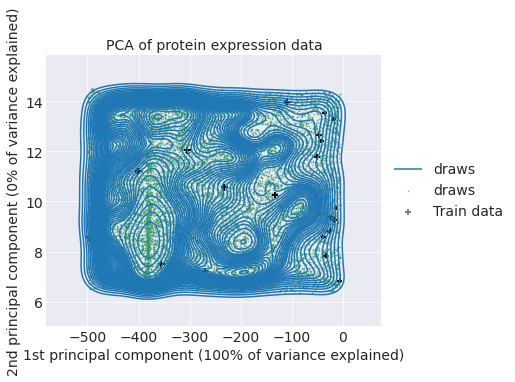

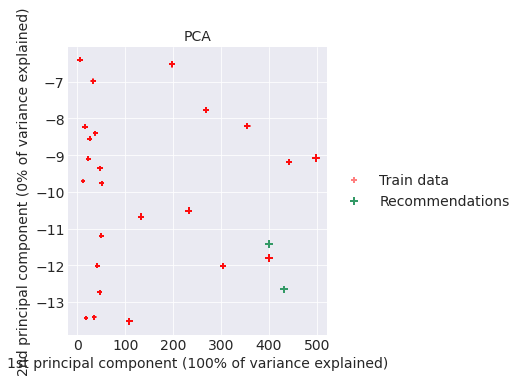

In [24]:
plot.draws_pc(art, draws, scale=100, plot_draws=True, plot_kde=True)
plot.recommendations_pc(art, scale=100)


In [25]:
plot.model_pairwise(art)

### Exploration recommendations

In [26]:
%%time
art.niter = 100000
art.alpha = user_params['alpha_explor']
draws = art.parallel_tempering_opt()


Finished 2.00 percent in 9.614099 s Acceptance rate = 0.589Adding DE jump with weight 20
Finished 99.00 percent in 333.001997 s Acceptance rate = 0.413152
Run Complete
CPU times: user 5min 24s, sys: 1.83 s, total: 5min 25s
Wall time: 5min 36s


In [27]:
art.num_recommendations = user_params['n_instances_explor']
art.rel_rec_distance = 1
art.recommend(draws)

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340
0,0.005745,0.178462,2.566031,0.020569,13.908467,5.114123,452.178111,0.000281,0.002103,0.000487,0.005531,0.000835,0.585844
1,0.023718,0.186155,2.260340,0.098952,7.259735,3.147267,463.273237,0.000247,0.002706,0.000609,0.001650,0.000835,0.582538
2,0.037661,0.148863,1.889383,0.005116,12.763576,4.116574,406.030090,0.000133,0.002678,0.000584,0.006399,0.000835,0.578920
3,0.037661,0.148863,1.889383,0.005116,12.763576,4.116574,406.030090,0.000268,0.002678,0.000592,0.006399,0.000835,0.580718
4,0.015492,0.156280,1.548419,0.088349,8.437720,4.629115,458.741766,0.000063,0.001179,0.000906,0.006884,0.000835,0.570999
5,0.018674,0.154890,4.665777,0.087956,7.516629,3.613807,388.506705,0.000033,0.001601,0.000992,0.007470,0.000835,0.563377
6,0.035077,0.191039,4.509529,0.046849,11.911456,1.868015,363.160314,0.000111,0.002469,0.000992,0.007373,0.000835,0.578984
7,0.003919,0.200094,6.212248,0.027926,13.059003,2.502780,357.553813,0.000280,0.000078,0.000992,0.005548,0.000835,0.567518
8,0.018345,0.187632,5.571782,0.074321,8.342787,4.429468,376.703506,0.000076,0.001788,0.000992,0.007886,0.000835,0.561157
9,0.029671,0.192432,6.308068,0.062915,8.440861,4.636515,392.852934,0.000174,0.002881,0.000262,0.006224,0.000835,0.568787


In [32]:
# file = f"{user_params['output_file_path']}/draws_explor.txt"
# draws_explor = np.loadtxt(file)
# draws_explor = draws_explor[:, :-2]

# art.num_recommendations = user_params['n_instances_explor']
# art.rel_rec_distance = 1
# art.recommend(draws_explor)

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340
0,0.005745,0.178462,2.566031,0.020569,13.908467,5.114123,452.178111,0.000281,0.002103,0.000487,0.005531,0.000835,0.585844
1,0.023718,0.186155,2.260340,0.098952,7.259735,3.147267,463.273237,0.000247,0.002706,0.000609,0.001650,0.000835,0.582538
2,0.037661,0.148863,1.889383,0.005116,12.763576,4.116574,406.030090,0.000133,0.002678,0.000584,0.006399,0.000835,0.578920
3,0.037661,0.148863,1.889383,0.005116,12.763576,4.116574,406.030090,0.000268,0.002678,0.000592,0.006399,0.000835,0.580718
4,0.015492,0.156280,1.548419,0.088349,8.437720,4.629115,458.741766,0.000063,0.001179,0.000906,0.006884,0.000835,0.570999
5,0.018674,0.154890,4.665777,0.087956,7.516629,3.613807,388.506705,0.000033,0.001601,0.000992,0.007470,0.000835,0.563377
6,0.035077,0.191039,4.509529,0.046849,11.911456,1.868015,363.160314,0.000111,0.002469,0.000992,0.007373,0.000835,0.578984
7,0.003919,0.200094,6.212248,0.027926,13.059003,2.502780,357.553813,0.000280,0.000078,0.000992,0.005548,0.000835,0.567518
8,0.018345,0.187632,5.571782,0.074321,8.342787,4.429468,376.703506,0.000076,0.001788,0.000992,0.007886,0.000835,0.561157
9,0.029671,0.192432,6.308068,0.062915,8.440861,4.636515,392.852934,0.000174,0.002881,0.000262,0.006224,0.000835,0.568787


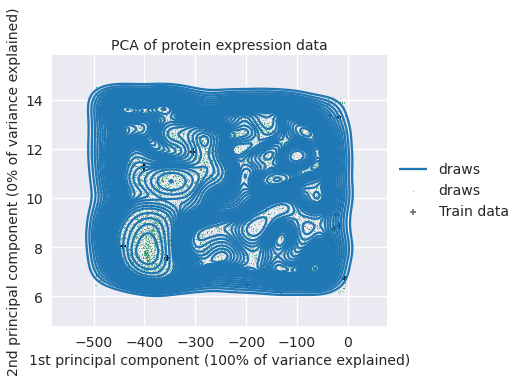

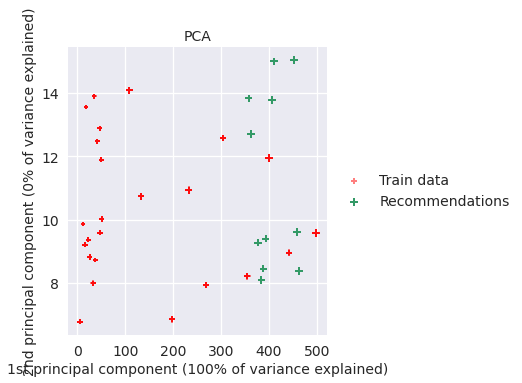

In [34]:
plot.draws_pc(art, draws, scale=100, plot_draws=True, plot_kde=True)
plot.recommendations_pc(art, scale=100)


In [33]:
df_rec_explor = art.recommendations.copy()


In [34]:
predicted_mean, predicted_std = art.post_pred_stats(
            df_rec_explor.values[:, :-1]
        )

df_rec_explor['OD340_std'] = predicted_std
df_rec_explor['Label'] = 'exploration'

In [35]:
df_rec = df_rec_exploit.append(df_rec_explor)

In [36]:
df_rec = df_rec.rename(columns={"OD340": "OD340_pred"})

### Generate the control media 

Read the standard recipe:

In [37]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")

Control media will be uniformly drawn from the interval 90% to 110% around the standard recipe.

In [38]:
# d = np.array([0.0037091793918082500, 0.3055248500503110,1.2435684044200400,0.009371840883599310,9.94303656748339,0.47229306744708200,53.32666134961220,2.92867492615239E-05,0.00031239989642707500,9.42840717674312E-05,0.0008494249888602220,9.76389135980585E-05]),

# df_control = pd.DataFrame(d,
#     columns=user_params['components']
# )
# df_control

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
0,0.003709,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098


In [31]:
ub = 1.1
lb = 0.9
df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = df_stand.loc[component]['Concentration[mM]']
    df_control.at['Control', component] = stand_conc*np.random.uniform(lb, ub)

df_control

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
Control,0.003709,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098


Check that these controls are not equivalent to the previously tested:

In [39]:
for component in user_params['components']:
     assert(all(df_control.at['Control', component] != control_lines[component]))

KeyError: 'Control'

Add ART's prediction for this design

In [40]:
control_predicted_mean, control_predicted_std = art.post_pred_stats(
            df_control.values
        )
df_control['OD340_pred'] = control_predicted_mean
df_control['OD340_std'] = control_predicted_std
df_control['Label'] = 'standard'

In [41]:
df_control

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340_pred,OD340_std,Label
0,0.003709,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098,0.287262,0.066246,standard


In [42]:
df_rec = df_rec.append(df_control).reset_index(drop=True)
df_rec

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340_pred,OD340_std,Label
0,0.028304,0.203775,2.142815,0.049850,10.682077,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0.602671,0.066540,exploitation
1,0.038344,0.196104,2.505369,0.065130,11.989143,3.103421,431.048016,0.000195,0.000292,0.000689,0.002345,0.000014,0.600444,0.066787,exploitation
2,0.038343,0.196097,2.505370,0.053723,11.989142,3.103433,431.048016,0.000189,0.000292,0.000689,0.007345,0.000014,0.593921,0.067319,exploitation
3,0.005745,0.178462,2.566031,0.020569,13.908467,5.114123,452.178111,0.000281,0.002103,0.000487,0.005531,0.000835,0.585844,0.067774,exploration
4,0.023718,0.186155,2.260340,0.098952,7.259735,3.147267,463.273237,0.000247,0.002706,0.000609,0.001650,0.000835,0.582538,0.067739,exploration
5,0.037661,0.148863,1.889383,0.005116,12.763576,4.116574,406.030090,0.000133,0.002678,0.000584,0.006399,0.000835,0.578920,0.067792,exploration
6,0.037661,0.148863,1.889383,0.005116,12.763576,4.116574,406.030090,0.000268,0.002678,0.000592,0.006399,0.000835,0.580718,0.067721,exploration
7,0.015492,0.156280,1.548419,0.088349,8.437720,4.629115,458.741766,0.000063,0.001179,0.000906,0.006884,0.000835,0.570999,0.067878,exploration
8,0.018674,0.154890,4.665777,0.087956,7.516629,3.613807,388.506705,0.000033,0.001601,0.000992,0.007470,0.000835,0.563377,0.068036,exploration
9,0.035077,0.191039,4.509529,0.046849,11.911456,1.868015,363.160314,0.000111,0.002469,0.000992,0.007373,0.000835,0.578984,0.067560,exploration


### Check the distribution of designs

Define dataframe with train data and predictions:

In [52]:
df_train = df[user_params['components']]
df_train['OD340'] = df['OD340']

Add predictions, cv-predictions and standard deviation of the OD340 predictions:

In [53]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train.values[:, :-1]
        )

In [54]:
df_train['OD340_pred'] = train_predicted_mean
df_train['OD340_std'] = train_predicted_std
df_train['OD340_cv_pred'] = art.model_df_cv[0]["Predictions"]["Ensemble Model"]
df_train['OD340_cv_std'] = art.model_df_cv[0]["Predictions StDev"]["Ensemble Model"]

Add label for control lines:

In [55]:
df_train['Label'] = None

In [56]:
df_train.loc[control_lines.index, 'Label'] = 'standard'

In [57]:
df_train

Protocol,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340,OD340_pred,OD340_std,OD340_cv_pred,OD340_cv_std,Label
0,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.4422,0.374856,0.066248,0.478344,0.037749,None
1,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3405,0.374856,0.066248,0.478344,0.037749,None
2,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3397,0.374856,0.066248,0.478344,0.037749,None
3,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3602,0.374856,0.066248,0.478344,0.037749,None
4,0.009185,0.380499,1.156774,0.007971,11.618192,5.030266,50.60791,0.000155,0.000152,0.000029,0.00041,0.000277,0.2699,0.273986,0.066338,0.276293,0.063466,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.002467,0.119844,1.762672,0.081953,8.821329,0.279924,25.780235,0.000205,0.000291,0.000455,0.00017,0.000743,0.3065,0.307097,0.066331,0.410657,0.063867,None
92,0.003929,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095,0.2934,0.295136,0.066248,0.259378,0.057191,standard
93,0.003929,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095,0.2912,0.295136,0.066248,0.259378,0.057191,standard
94,0.003929,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095,0.3004,0.295136,0.066248,0.259378,0.057191,standard


Save train data set for this cycle:

In [58]:
file = f"{user_params['output_file_path']}/train_pred.csv"
df_train.to_csv(file)

In [123]:
def designs_pairwise(art, df_rec, df_train=None):

    dim = art.num_input_var

    plt.style.use('seaborn-whitegrid')

    fig = plt.figure(figsize=(35, 35))
    fig.patch.set_facecolor("white")

    X = df_rec[user_params['components']].values
    X_train = df_train[user_params['components']].values
    standard = df_train[df_train['Label']=='standard'].drop(columns='Label').values

    for var1 in range(dim):
        for var2 in range(var1 + 1, dim):

            ax = fig.add_subplot(dim, dim, (var2 * dim + var1 + 1))
            ax.scatter(
                X_train[:, var1],
                X_train[:, var2],
                c="r",
                marker="+",
                s=150*df_train['OD340'],
                lw=1,
                label="Train data",
            )
            
            ax.scatter(
                standard[:, var1],
                standard[:, var2],
                c="k",
                marker="+",
                s=150*standard[:, -1].astype(float),
                lw=1,
                label="Standard",
            )
            
            ax.scatter(
                X[:, var1],
                X[:, var2],
                c="g",
                marker="+",
                s=150*df_rec['OD340_pred'],
                lw=1,
                label="Recommendations",
            )
            
            ax.scatter(
                X[-1, var1],
                X[-1, var2],
                c="k",
                marker="+",
                s=150*df_rec['OD340_pred'].values[-1],
                lw=1,
                label="Standard",
            )
            
            
                        
            if var2 == (dim - 1):
                ax.set_xlabel(art.input_vars[var1])
            if var1 == 0:
                ax.set_ylabel(art.input_vars[var2])
                if var2 == 0:
                    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), shadow=True)

    fig.savefig(
        f'{art.outDir}/designs_pairwise.png',
        bbox_inches="tight",
        transparent=False, 
        dpi=300
    )

In [118]:
import matplotlib.pyplot as plt

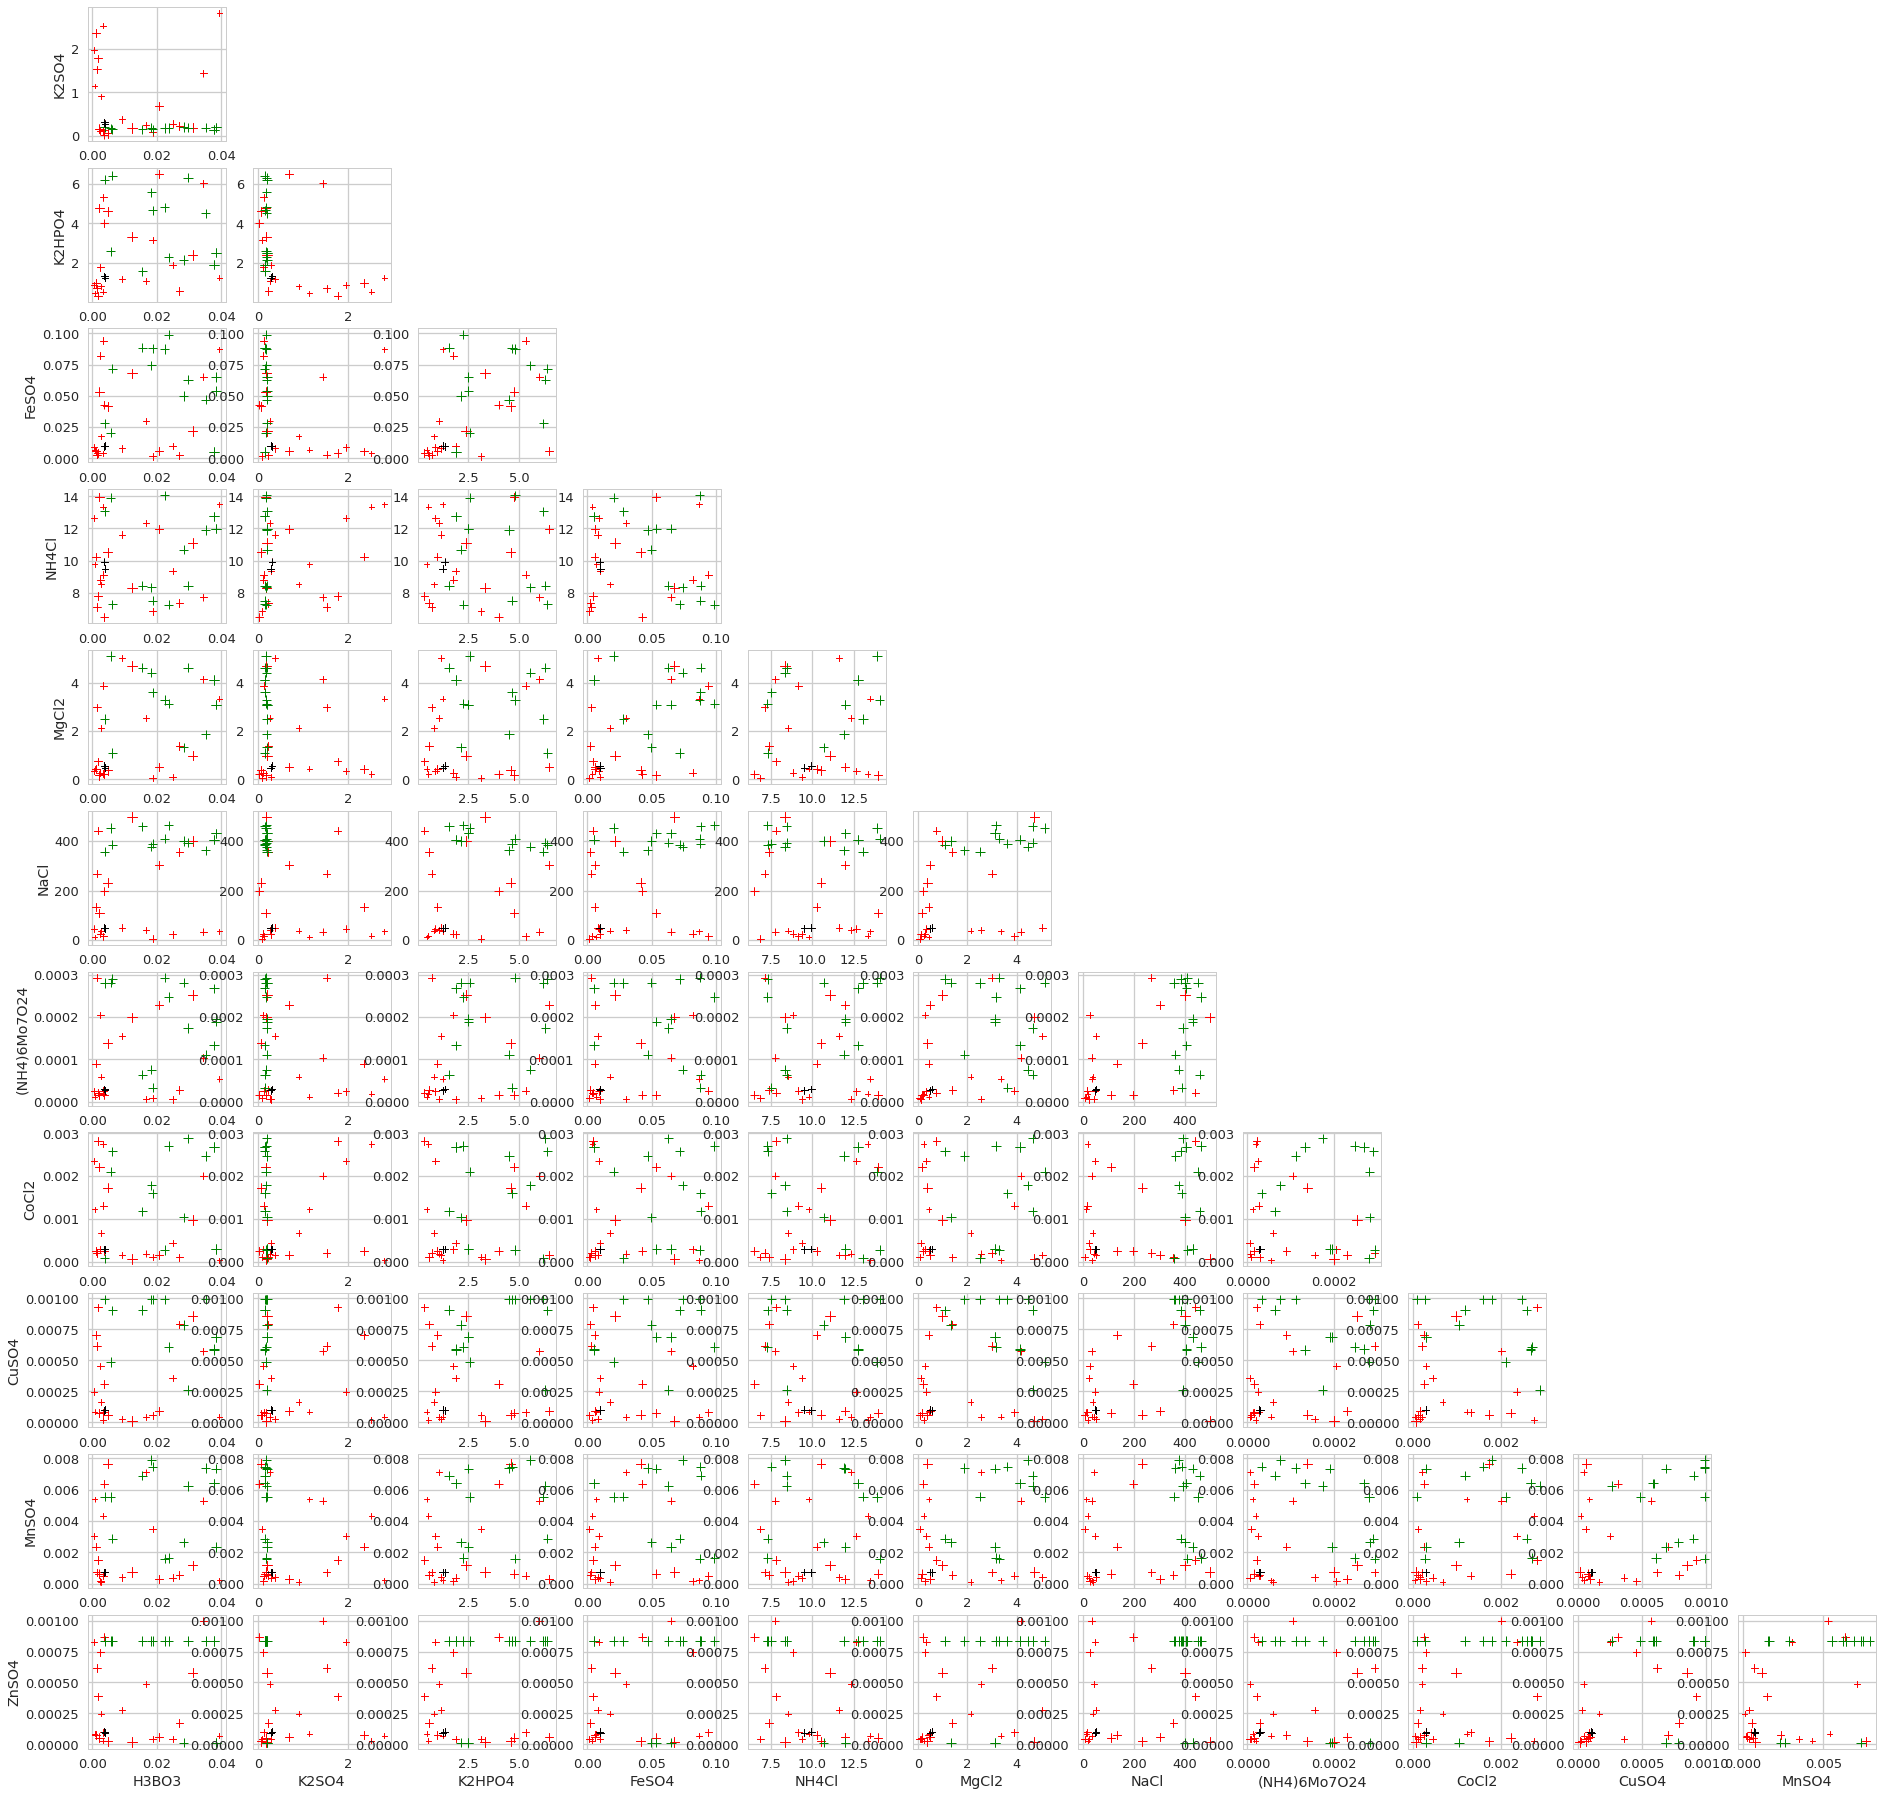

In [124]:
designs_pairwise(art, df_rec, df_train)

## Saving the generated designs

Include all replicates: 

In [43]:
df_rec = df_rec.loc[df_rec.index.repeat(user_params['n_replicates'])]


Rename index to well names:

In [44]:
well_rows = 'ABCDEF'
well_columns = '12345678'

In [45]:
well_names = [f'{row}{column}'  for column in well_columns for row in well_rows]

df_rec['Well'] = well_names
df_rec = df_rec.set_index(['Well'])
df_rec.head()

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340_pred,OD340_std,Label
Well,,,,,,,,,,,,,,,
A1,0.028304,0.203775,2.142815,0.04985,10.682077,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0.602671,0.066540,exploitation
B1,0.028304,0.203775,2.142815,0.04985,10.682077,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0.602671,0.066540,exploitation
C1,0.028304,0.203775,2.142815,0.04985,10.682077,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0.602671,0.066540,exploitation
D1,0.038344,0.196104,2.505369,0.06513,11.989143,3.103421,431.048016,0.000195,0.000292,0.000689,0.002345,0.000014,0.600444,0.066787,exploitation
E1,0.038344,0.196104,2.505369,0.06513,11.989143,3.103421,431.048016,0.000195,0.000292,0.000689,0.002345,0.000014,0.600444,0.066787,exploitation


In [46]:
file = f"{user_params['output_file_path']}/target_concentrations.csv"
df_rec[user_params['components']].to_csv(file)

In [47]:
file = f"{user_params['output_file_path']}/target_concentrations_pred.csv"
df_rec.to_csv(file)